In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, to_graphviz
from sklearn.metrics import classification_report, plot_confusion_matrix,roc_curve, accuracy_score, roc_auc_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
import matplotlib.pyplot as plt
import graphviz
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")
import seaborn as sns
os.chdir("C:/Users/Cem/Desktop/Staj/Data")
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin/"
import time

In [2]:
seeds = pd.read_csv("seeds.csv")
seeds.drop("ID",axis=1,inplace=True)
colnames = np.array(seeds.drop("seedType",axis=1).columns)

## Eksik Gözlem Kontrolü

In [4]:
seeds

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


## Boxplot İle Aykırı Değer Kontrolü

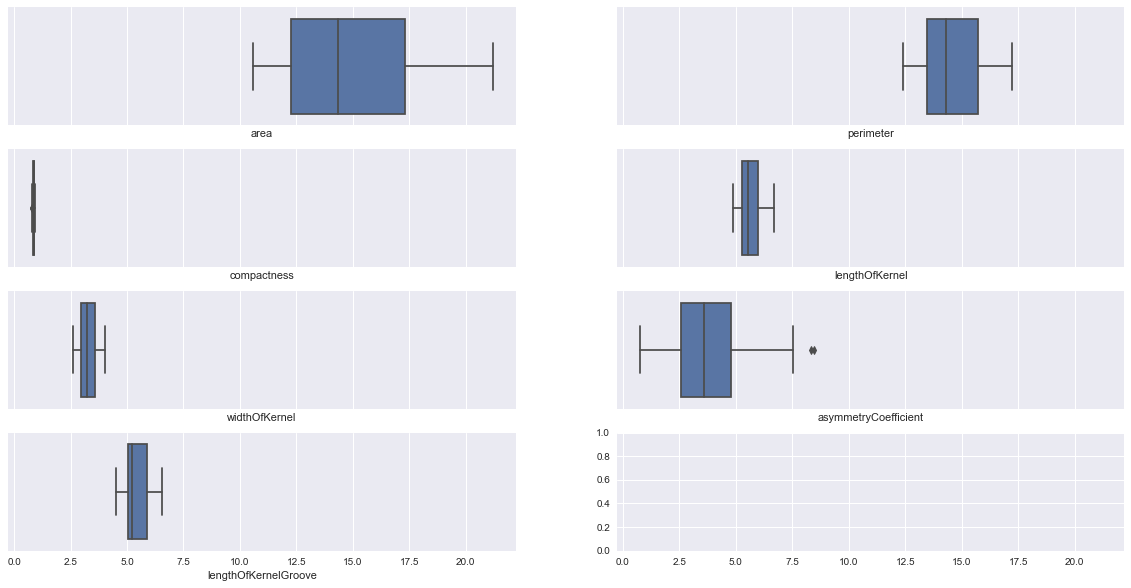

In [4]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(20,10))
inde = 0
for i in range(4):
    for j in range(2):
        if inde < colnames.shape[0]:
            sns.boxplot(x=colnames[inde],data=seeds,ax=axes[i,j]);
            inde+=1

In [5]:
IQR = seeds.asymmetryCoefficient.quantile(0.75) - seeds.asymmetryCoefficient.quantile(0.25)
uppB = seeds.asymmetryCoefficient.quantile(0.75) + 1.5*IQR

## Aykırı değerlerin veri setinden atılması

In [6]:
seeds[seeds.asymmetryCoefficient >= uppB]
seedsNew = seeds.drop(index=[203,207],axis=0)

In [7]:
X = seedsNew.drop("seedType",axis=1)
y = seedsNew.seedType -1 

## Değişkenler Arası İlişkinin İncelenmesi

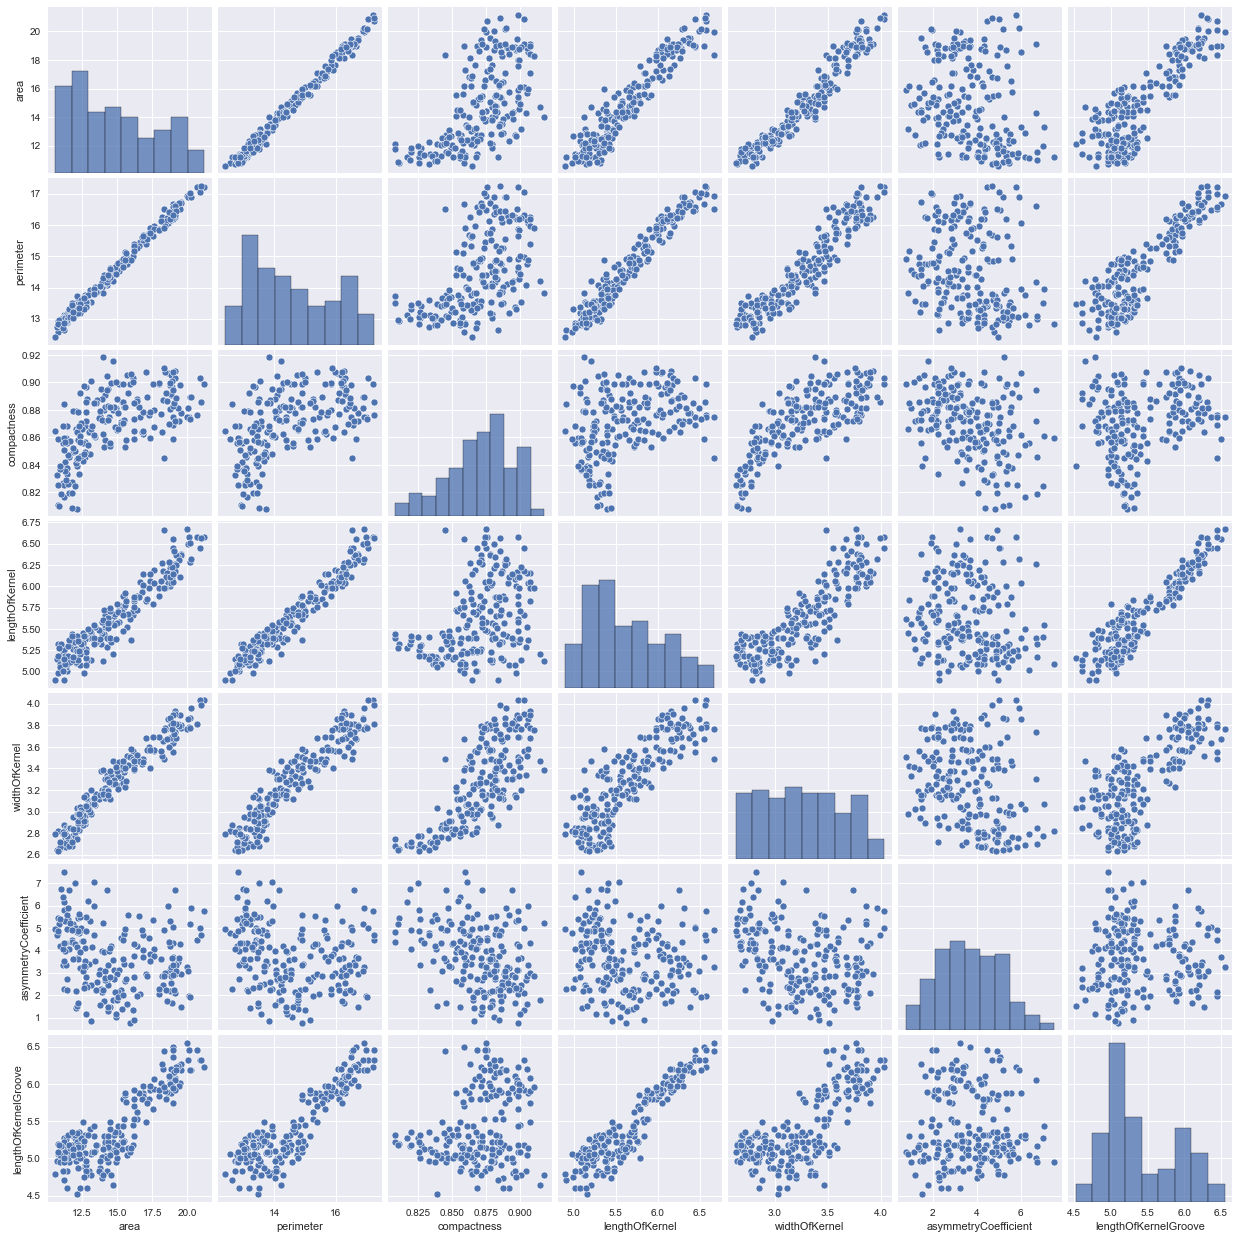

In [8]:
sns.pairplot(X);

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y,test_size=0.25)

## Model Kurulumları ve Seçimleri

		Logistic Regression Results

              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.83      0.88      0.86        17
           2       0.89      1.00      0.94        17

    accuracy                           0.87        52
   macro avg       0.86      0.87      0.86        52
weighted avg       0.86      0.87      0.86        52



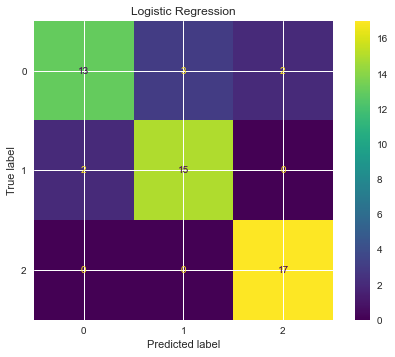

In [65]:
logisticModel = LogisticRegression("l2",solver="saga",dual=False).fit(X_train,y_train);
predLogistic = logisticModel.predict(X_test)
acsLogi = accuracy_score(y_test,predLogistic)
print("\t\tLogistic Regression Results\n")
print(classification_report(y_test,predLogistic))
plot_confusion_matrix(logisticModel,X_test,y_test);
plt.title("Logistic Regression");
aucLogi = roc_auc_score(y_test, logisticModel.predict_proba(X_test), multi_class='ovr')

              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.88      0.88      0.88        17
           2       0.85      1.00      0.92        17

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.86        52
weighted avg       0.87      0.87      0.86        52



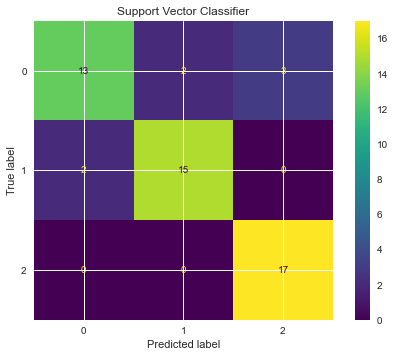

In [66]:
modelSVC = SVC(kernel="rbf",probability=True).fit(X_train,y_train)
predModelSVC = modelSVC.predict(X_test)
acsSVC = accuracy_score(y_test,predModelSVC)
print(classification_report(y_test,predModelSVC))
plot_confusion_matrix(modelSVC,X_test,y_test)
plt.title("Support Vector Classifier");
aucSVC = roc_auc_score(y_test, modelSVC.predict_proba(X_test), multi_class='ovr')

              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.94      0.88      0.91        17
           2       0.81      1.00      0.89        17

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.86        52
weighted avg       0.87      0.87      0.86        52



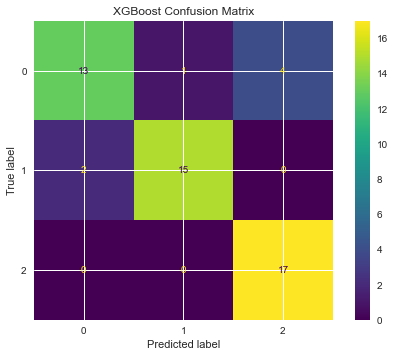

In [67]:
modelXGB = XGBClassifier(use_label_encoder=False,
                        learning_rate=0.01,
                        gamma=1,
                        eval_metric="mlogloss").fit(X_train,y_train)
predModelXGB = modelXGB.predict(X_test)
aucXGB = roc_auc_score(y_test, modelXGB.predict_proba(X_test), multi_class='ovr')
plt.title("XGBoost Confusion Matrix")
print(classification_report(y_test,predModelXGB))


              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.94      0.94      0.94        17
           2       0.89      1.00      0.94        17

    accuracy                           0.92        52
   macro avg       0.92      0.92      0.92        52
weighted avg       0.92      0.92      0.92        52



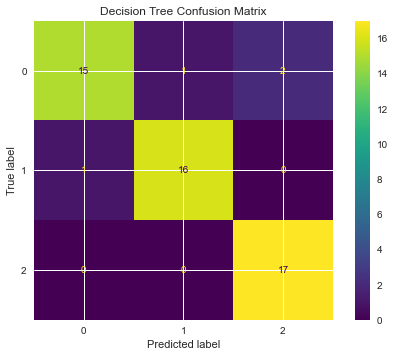

In [68]:
modelDTC = DecisionTreeClassifier(random_state=42).fit(X_train,y_train)
predModelDTC = modelDTC.predict(X_test)
acsDTC = accuracy_score(y_test,predModelDTC)
aucDTC = roc_auc_score(y_test, modelDTC.predict_proba(X_test), multi_class='ovr')
plt.title("Decision Tree Confusion Matrix")
print(classification_report(y_test,predModelDTC))

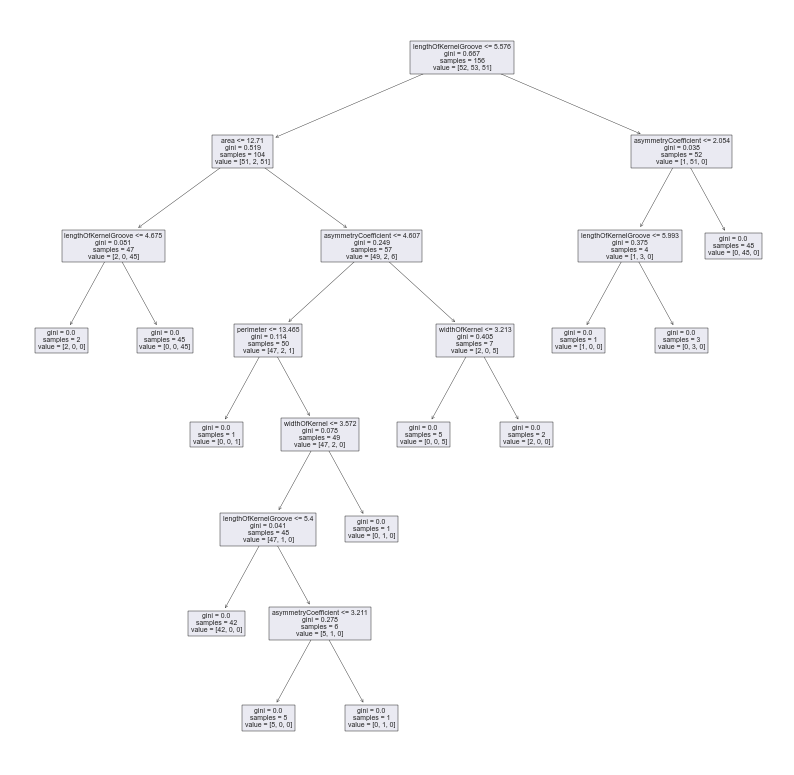

In [23]:
fig = plt.figure(figsize=(10,10),dpi=100)
_ = plot_tree(modelDTC,feature_names=X.columns);
fig.savefig("DecisionTree.jpg");

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.94      0.88      0.91        17
           2       0.84      0.94      0.89        17

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.87        52
weighted avg       0.87      0.87      0.86        52



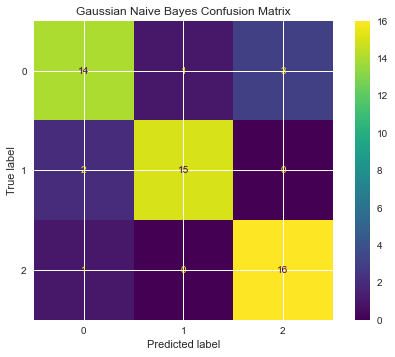

In [69]:
modelNB = GaussianNB().fit(X_train,y_train)
predModelNaive = modelNaive.predict(X_test)
acsNB = accuracy_score(y_test,predModelNaive)
aucNB = roc_auc_score(y_test, modelNB.predict_proba(X_test), multi_class='ovr')
plt.title("Gaussian Naive Bayes Confusion Matrix")
print(classification_report(y_test,predModelNaive))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.94      1.00      0.97        17
           2       0.85      1.00      0.92        17

    accuracy                           0.92        52
   macro avg       0.93      0.93      0.92        52
weighted avg       0.93      0.92      0.92        52



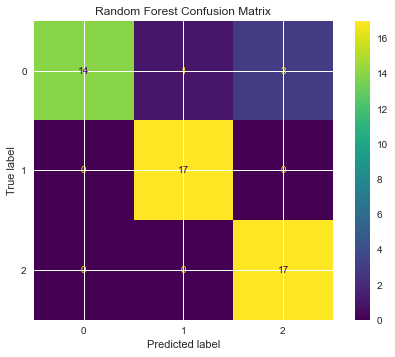

In [70]:
modelRF = RandomForestClassifier(n_estimators=300).fit(X_train,y_train)
predModelRF = modelRF.predict(X_test)
acsRF = accuracy_score(y_test,predModelRF)
aucRF = roc_auc_score(y_test, modelRF.predict_proba(X_test), multi_class='ovr')
plt.title("Random Forest Confusion Matrix")
print(classification_report(y_test,predModelRF))

              precision    recall  f1-score   support

           0       0.86      0.67      0.75        18
           1       0.83      0.88      0.86        17
           2       0.85      1.00      0.92        17

    accuracy                           0.85        52
   macro avg       0.85      0.85      0.84        52
weighted avg       0.85      0.85      0.84        52



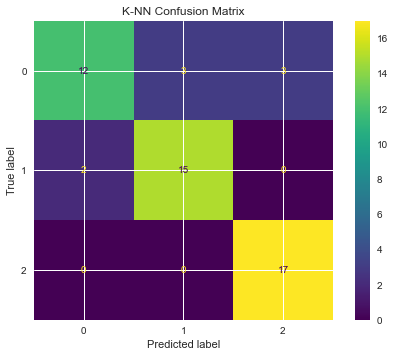

In [71]:
modelNN = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)
predModelNN = modelNN.predict(X_test)
acsNN = accuracy_score(y_test,predModelNN)
aucNN = roc_auc_score(y_test, modelNN.predict_proba(X_test), multi_class='ovr')
plt.title("K-NN Confusion Matrix")
print(classification_report(y_test,predModelNN))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.83      0.88      0.86        17
           2       0.94      0.94      0.94        17

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.87        52
weighted avg       0.87      0.87      0.86        52



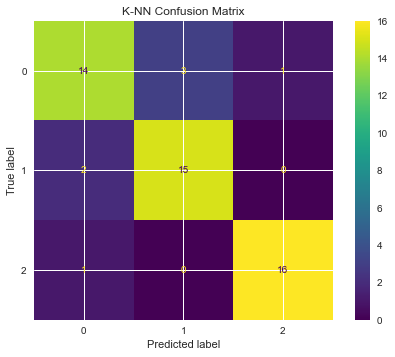

In [72]:
modelNeu = MLPClassifier().fit(X_train,y_train)
predModelNeu = modelNeu.predict(X_test)
acsNeu = accuracy_score(y_test,predModelNeu)
aucNeu = roc_auc_score(y_test, modelNeu.predict_proba(X_test), multi_class='ovr')
plot_confusion_matrix(modelNeu,X_test,y_test)
plt.title("K-NN Confusion Matrix")
print(classification_report(y_test,predModelNeu))

In [73]:
acuDF = pd.DataFrame({"Model":[],"Accuracy":[]})
aucDF = pd.DataFrame({"Model":[],"AUC":[]})
models= ["Logistic Regression","Support Vector Machine","Decision Tree","XGBoost","Random Forest","Naive Bayes","K-NN","Neural Networks"]
accuracy = [acsLogi,acsSVC,acsDTC,acsXGB,acsRF,acsNB,acsNN,acsNeu]
aucs = [aucLogi,aucSVC,aucDTC,aucXGB,aucRF,aucNB,aucNN,aucNeu]
for i,j,z in zip(models,accuracy,aucs):
    acuDF = acuDF.append({"Model":i,"Accuracy":j*100},ignore_index=True)
    aucDF = aucDF.append({"Model":i,"AUC":z*100},ignore_index=True)

# Modellerin Accuracy Değerleri Karşılaştırılması

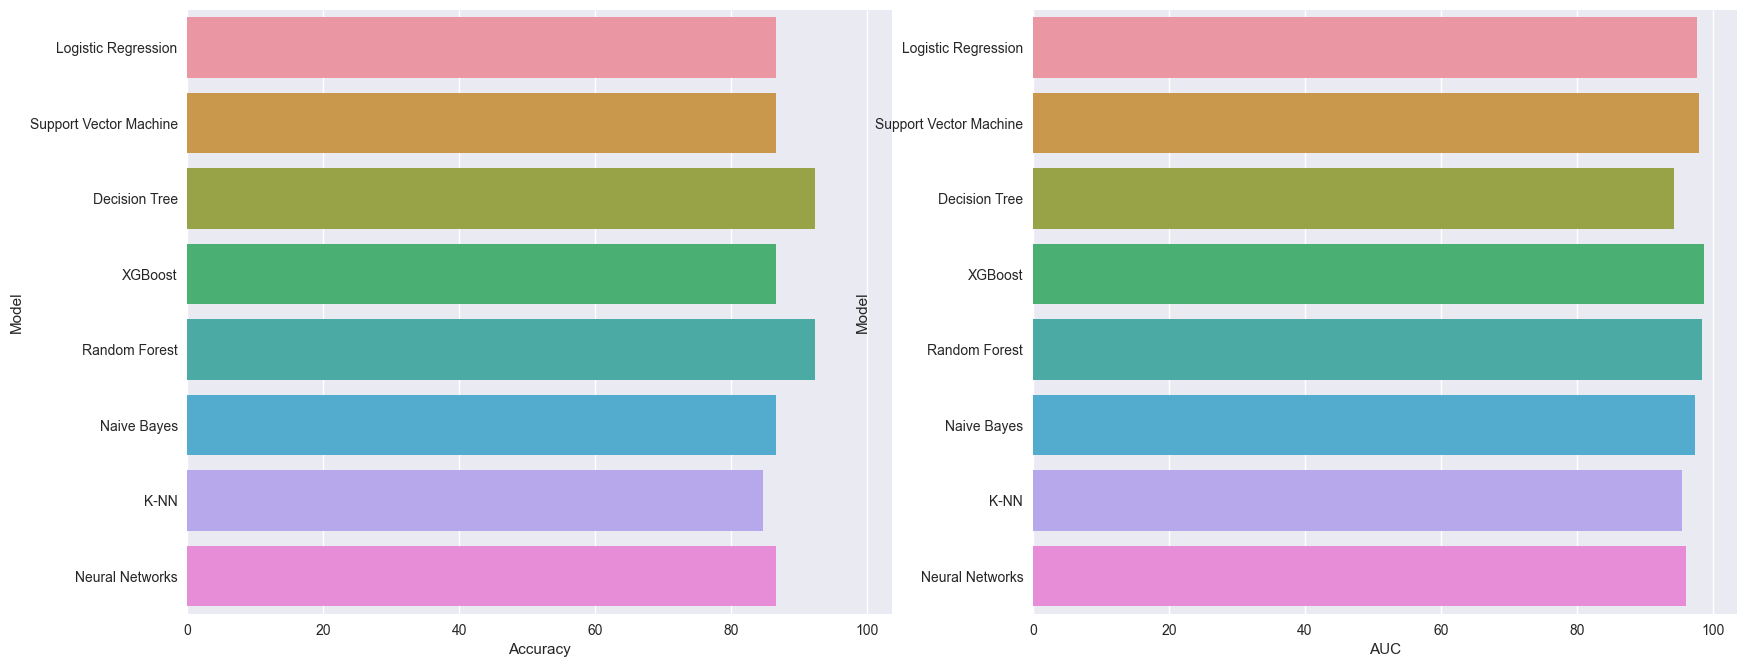

In [90]:
fig, axs = plt.subplots(1,2,sharex=True,figsize=(20,8),dpi=100)
sns.barplot(x="Accuracy",y="Model",data=acuDF,ax=axs[0]);
sns.barplot(x="AUC",y="Model",data=aucDF,ax=axs[1]);

### Sonuç olarak elimizdeki veri setinde Rassal ormanlar her iki metrik içinde üst düzey performanslar gösterip bu veri setimiz için en başarılı algoritma olmuştur.

In [ ]:
t1 = time.time()
param_grid = {"n_estimators":np.arange(1,500,50),
              "criterion":["gini","entropy"],
              "max_depth":np.arange(1,20),
              "min_samples_split":[1,2,3,4],
              "max_features":["auto","sqrt","log2"],
              "bootstrap":[True,False]}
clf = GridSearchCV(RandomForestClassifier(),param_grid,n_jobs=-1,verbose=1)
clf.fit(X_train,y_train)
t2 = time.time()
print(f"Geçen süre {t2-t1}")

Fitting 5 folds for each of 9120 candidates, totalling 45600 fits
